# Equação de estado e equilíbrio líquido-vapor para mistura binária

In [1]:
import numpy as np
#pacote para fazer vetores

from matplotlib import pyplot as plt
#pacote para desenhar graficos

%matplotlib inline
#configuração de desenho do gráfico no campo de resultado da célula no próprio arquivo ipynb

# unidades

In [2]:
R=8.314

# Sistema modelado:

In [3]:
#nC5
Tc1= 469.7 #K
Pc1= 33.7e5 #Pa
omega1=0.252


#Benzeno
Tc2= 562.2 #K
Pc2= 48.98e5 #Pa
omega2= 0.210

#nC5
def func_Psat1_Antoine(T):
    A1 = 13.7667
    B1 = 2451.88
    C1 = 232.014
    Psat1=10**3*np.exp(A1-B1/(T-273.15+C1))
    return Psat1

#Benzeno
def func_Psat2_Antoine(T):
    A2=13.7819
    B2=2726.81
    C2=217.572
    Psat2=10**3*np.exp(A2-B2/(T-273.15+C2))
    return Psat2

## A equação de Peng-Robinson para mistura

In [4]:
def func_P_PengRobinson(T,V,x1,x2):
    bm=func_bmix(x1=x1,x2=x2)
    am=func_amix(T=T,x1=x1,x2=x2)
    return R*T/(V-bm)-am/(V**2+u*bm*V+w*bm**2)

#parametros da equação de estado
u=2
w=-1

b1=0.07780*R*Tc1/Pc1

def func_a1(T):
    Tr1=T/Tc1
    return (0.45724*R**2*Tc1**2/Pc1)*(1+f_omega1*(1-np.sqrt(Tr1)))**2

f_omega1 = 0.37464 + 1.54226*omega1-0.26992*omega1**2

b2=0.07780*R*Tc2/Pc2

def func_a2(T):
    Tr2=T/Tc2
    return (0.45724*R**2*Tc2**2/Pc2)*(1+f_omega2*(1-np.sqrt(Tr2)))**2

f_omega2 = 0.37464 + 1.54226*omega2-0.26992*omega2**2

def func_bmix(x1,x2):
    bm = b1*x1+b2*x2
    return bm

def func_amix(T,x1,x2): #para kij zero
    a1=func_a1(T=T)
    a2=func_a2(T=T)
    am= x1*x1*np.sqrt(a1*a1)+ \
        x1*x2*np.sqrt(a1*a2)+ \
        x2*x1*np.sqrt(a2*a1)+ \
        x2*x2*np.sqrt(a2*a2)
    return am

## Cálculo de isopletas de temperatura e composição

In [5]:
Ttest=298
nV=100
x1test=.1
x2test=.9

bmtest=func_bmix(x1=x1test,x2=x2test)

minV= bmtest*1.01
maxV= 1e-1 #m3/mol

seqV= np.logspace(np.log10(minV),np.log10(maxV),nV)
seqP=np.zeros(nV)

for i in range(nV):
    seqP[i]=func_P_PengRobinson(T=Ttest,V=seqV[i],x1=x1test,x2=x2test)

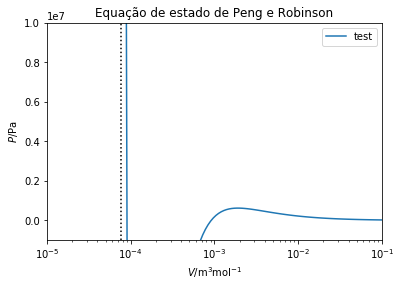

In [6]:
plt.plot(seqV,seqP,label='test') 
plt.axvline(bmtest,color='black',ls=':')

plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$')
plt.ylabel(r'$P / \mathrm{Pa}$')
plt.title('Equação de estado de Peng e Robinson') 
plt.ylim(-1e6,1e7)
plt.xlim(1e-5,1e-1) 
plt.xscale('log')
plt.legend()
plt.show()

## Cálculo de volume

vL, vV, nVphys
8.95654170542e-05 0.0236542569148 3


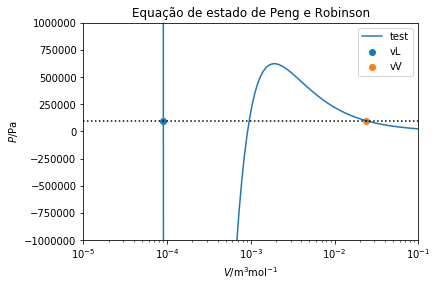

In [7]:
def func_VL_VV_cubic(T,P,x1,x2):
    am=func_amix(T=T,x1=x1,x2=x2)
    A=am*P/(R**2*T**2)
    bm=func_bmix(x1=x1,x2=x2)
    B=bm*P/(R*T)
    
    c3=1 
    c2=-(1+B-u*B)
    c1=(A+w*B**2-u*B-u*B**2)
    c0=-A*B-w*B**2-w*B**3
    
    list_coeffs=[c3,c2,c1,c0]

    Z1,Z2,Z3=np.roots(list_coeffs) #Como c3=1, nunca vai vir menos de três raízes (incluindo real e complexa)
    
    V1=Z1*R*T/P
    V2=Z2*R*T/P
    V3=Z3*R*T/P
        
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3]:
        if (abs(V.imag) < imag_tol) and (V.real > bm): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    vL=min(listVphysical) #se shouver apenas um V físico a função vai retornar valores de Volume iguais para liq e vap
    vV=max(listVphysical) 
    
    return vL, vV, nVphysical

Ptest=1e5
vL, vV, nVphys  = func_VL_VV_cubic(T=Ttest,P=Ptest,x1=x1test,x2=x2test)
print ("vL, vV, nVphys")     
print(vL, vV, nVphys)    
    
plt.plot(seqV,seqP,label='test') 
plt.scatter(vL,Ptest,label="vL") 
plt.scatter(vV,Ptest,label="vV") 
plt.axhline(Ptest,color='black',ls=':')

plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$')
plt.ylabel(r'$P / \mathrm{Pa}$')
plt.title('Equação de estado de Peng e Robinson') 
plt.ylim(-1e6,1e6)
plt.xlim(1e-5,1e-1) 
plt.xscale('log')
plt.legend()
plt.show()  

# Coeficientes de fugacidade

In [8]:
def func_lnphi1(T,P,Z,x1,x2):
    bm = func_bmix(x1=x1,x2=x2)
    B=bm*P/(R*T)
    am = func_amix(T=T,x1=x1,x2=x2)
    A=am*P/(R**2*T**2)
    a1=func_a1(T=T)
    sigma1=2*(a1/am)**.5    
    return (b1/bm)*(Z-1) - np.log(Z-B) + A/(B*((u**2-4*w))**.5)*(b1/bm-sigma1)*np.log((2*Z+B*(u+(u**2-4*w)**.5))/(2*Z+B*(u-(u**2-4*w)**.5)))

def func_lnphi2(T,P,Z,x1,x2):
    b = func_bmix(x1=x1,x2=x2)
    B=b*P/(R*T)
    a = func_amix(T=T,x1=x1,x2=x2)
    A=a*P/(R**2*T**2)
    a2=func_a2(T)
    sigma2=2*(a2/a)**.5
    return (b2/b)*(Z-1) - np.log(Z-B) + A/(B*((u**2-4*w))**.5)*(b2/b-sigma2)*np.log((2*Z+B*(u+(u**2-4*w)**.5))/(2*Z+B*(u-(u**2-4*w)**.5)))

Ttest=298
x1test=.5
x2test=.5
Ptest=1e5

Vm_Ltest,Vm_Vtest,nVphystest = func_VL_VV_cubic(T=Ttest,P=Ptest,x1=x1test, x2=x2test)

ZVtest=(Ptest*Vm_Vtest)/(R*Ttest)

lnphi1_test = func_lnphi1(T=Ttest,P=Ptest,Z=ZVtest,x1=x1test,x2=x2test)
lnphi2_test = func_lnphi2(T=Ttest,P=Ptest,Z=ZVtest,x1=x1test,x2=x2test)

print ("phi1", np.exp(lnphi1_test))
print ("phi2", np.exp(lnphi2_test))

phi1 0.95907759394
phi2 0.956332249343


In [9]:
def func_Gres1_RT(T,P,Z):    
    a=func_a1(T)
    A=a*P/(R**2*T**2)
    b=b1
    B=b*P/(R*T)
    T1=A/(B*(u**2-4*w)**.5)
    T2=(-1)
    T3=2*Z+B*(u+(u**2-4*w)**.5)
    T4=2*Z+B*(u-(u**2-4*w)**.5)
    Gres_RT_TPZ = (Z-1)-np.log(Z-B)+T1*T2*np.log(T3/T4)
    return Gres_RT_TPZ

def func_Gres2_RT(T,P,Z):    
    a=func_a2(T)
    A=a*P/(R**2*T**2)
    b=b2
    B=b*P/(R*T)
    T1=A/(B*(u**2-4*w)**.5)
    T2=(-1)
    T3=2*Z+B*(u+(u**2-4*w)**.5)
    T4=2*Z+B*(u-(u**2-4*w)**.5)
    Gres_RT_TPZ = (Z-1)-np.log(Z-B)+T1*T2*np.log(T3/T4)
    return Gres_RT_TPZ

Ttest=298
Ptest=1e5

Vmi_L,Vmi_V,nVphys = func_VL_VV_cubic(T=Ttest,P=Ptest,x1=1,x2=0)
ZVtest=R*Ttest/(Ptest*Vm_Vtest)
G1test = func_Gres1_RT(T=Ttest,P=Ptest,Z=ZVtest)
lnphi1test=func_lnphi1(T=Ttest,P=Ptest,Z=ZVtest,x1=1,x2=0)
print("(Gres1/RT):",(G1test), "ln(phi1):", lnphi1test)

Vmi_L,Vmi_V,nVphys = func_VL_VV_cubic(T=Ttest,P=Ptest,x1=0,x2=1)
ZVtest=R*Ttest/(Ptest*Vm_Vtest)
G2test = func_Gres2_RT(T=Ttest,P=Ptest,Z=ZVtest)
lnphi2test=func_lnphi2(T=Ttest,P=Ptest,Z=ZVtest,x1=0,x2=1)
print("(Gres2/RT):",(G2test), "ln(phi2):",lnphi2test)

(Gres1/RT): -0.0380873189661 ln(phi1): -0.0380873189661
(Gres2/RT): -0.0407048761148 ln(phi2): -0.0407048761148


# Cálculo de pressão de ponto de bolha

In [10]:
#estimativa inicial
def func_Pbolha_ideal(T,z1,z2):
    x1=z1
    x2=z2
    
    Psat1=func_Psat1_Antoine(T=T)
    Psat2=func_Psat2_Antoine(T=T)
    
    #calculo da pressao com a equaão classica P=somatorio(xi gammi psati)
    #     #gamma ideal
    #     gamma1=1
    #     gamma2=1
    P=x1*Psat1+x2*Psat2
    
    #calculo posterior das fracoes molares na fase gas
    y1=x1*Psat1/P
    y2=x2*Psat2/P
    
    return P, y1,y2

x1test=.5
x2test=.5
Ttest=298

print(func_Pbolha_ideal(T=Ttest,z1=x1test,z2=x2test))

(40359.666723757153, 0.84390233567079975, 0.15609766432920016)


In [11]:
#Pbolha_phiphi

#especificacao
x1=.5
x2=.5
T=298

#estimativa inicial de Pbolha
Pbolha, y1, y2 = func_Pbolha_ideal(T=T,z1=x1,z2=x2)
print(Pbolha, y1, y2)

P=Pbolha

#fugacidade do liquido

Vm_L,Vm_V,nVphys = func_VL_VV_cubic(T=T,P=P,x1=x1,x2=x2) 

ZL=(P*Vm_L)/(R*T)

phi1_L=np.exp( func_lnphi1(T=T,P=P,Z=ZL,x1=x1,x2=x2) )
phi2_L=np.exp( func_lnphi2(T=T,P=P,Z=ZL,x1=x1,x2=x2) )


f1_L=phi1_L*x1*P
f2_L=phi2_L*x2*P

print("f1_L:",f1_L,"f2_L:",f2_L)

j=0
res_loopP=1
soma_y=y1+y2
while (res_loopP>1e-9 and j<100):
    res_loopY=1 #qq coisa maior q 1e-6
    i=0
    while (res_loopY>1e-9 and i<100):
        #fugacidade do vapor
        
        Vm_L,Vm_V,nV = func_VL_VV_cubic(T=T,P=P,x1=y1/soma_y ,x2=y2/soma_y)
        ZV=(P*Vm_V)/(R*T)
        phi1_V=np.exp( func_lnphi1(T=T,P=P,Z=ZV,x1=y1/soma_y ,x2=y2/soma_y) )
        phi2_V=np.exp( func_lnphi2(T=T,P=P,Z=ZV,x1=y1/soma_y ,x2=y2/soma_y) )


        f1_V=phi1_V*y1*P
        f2_V=phi2_V*y2*P

        print('fug:',f1_V,f2_V)

        #calculando yi'
        y1_novo=y1*f1_L/f1_V
        y2_novo=y2*f2_L/f2_V
        print('y_novo:',y1_novo,y2_novo)

        res1=y1_novo-y1
        #print(res1)
        res2=y2_novo-y2
        #print(res2)
        res_loopY=abs(res1)+abs(res2)
        print('res_loopY:',res_loopY)

        soma_y=y1_novo+y2_novo #normalizacao dos y p/ entrar na eq de estado como uma fracao

        y1=y1_novo #salvando o novo como o 'y velho' da iteracao anterior
        y2=y2_novo
        i=i+1
        print('i:',i)

    res_loopP=abs(soma_y-1)
    P=P*soma_y #atualiza P
    print('P:',P)
    j=j+1
    print('j:',j)
    
Pbolha=P
print("P:", Pbolha,"y1:",y1,"y2:",y2,"i:",i,"j:",j)

40359.6667238 0.843902335671 0.156097664329
f1_L: 35811.3003389 f2_L: 7422.7272605
fug: 33495.8173333 6188.87697937
y_novo: 0.902239216877 0.187218196804
res_loopY: 0.0894574136802
i: 1
fug: 35811.3022732 7422.72521636
y_novo: 0.902239168144 0.187218248362
res_loopY: 1.00290151323e-07
i: 2
fug: 35811.3003389 7422.72726049
y_novo: 0.902239168144 0.187218248362
res_loopY: 3.04506420079e-13
i: 3
P: 43970.1382399
j: 1
fug: 38956.237829 8073.76685346
y_novo: 0.829401390602 0.172121640493
res_loopY: 0.0879343854112
i: 1
fug: 35811.300341 7422.72725845
y_novo: 0.829401390554 0.172121640541
res_loopY: 9.49889611412e-11
i: 2
P: 44037.1061277
j: 2
fug: 35864.840658 7433.81067452
y_novo: 0.828163230443 0.171865016383
res_loopY: 0.00149478426907
i: 1
fug: 35811.300339 7422.72726046
y_novo: 0.828163230442 0.171865016384
res_loopY: 1.76575420952e-12
i: 2
P: 44038.3500361
j: 3
fug: 35812.293321 7422.93281829
y_novo: 0.828140267623 0.171860257053
res_loopY: 2.77221501747e-05
i: 1
fug: 35811.3003389 74

In [12]:
def func_Pbolha_phiphi(T,x1,x2):
    #estimativa inicial de Pbolha
    P, y1, y2 = func_Pbolha_ideal(T=T,z1=x1,z2=x2)

    #fugacidade do liquido
    Vm_L,Vm_V,nVphys = func_VL_VV_cubic(T=T,P=P,x1=x1,x2=x2) 
    ZL=(P*Vm_L)/(R*T)
    phi1_L=np.exp( func_lnphi1(T=T,P=P,Z=ZL,x1=x1,x2=x2) )
    phi2_L=np.exp( func_lnphi2(T=T,P=P,Z=ZL,x1=x1,x2=x2) )
    f1_L=phi1_L*x1*P
    f2_L=phi2_L*x2*P

    j=0
    res_loopP=1
    soma_y=y1+y2
    while (res_loopP>1e-6 and j<100):
        res_loopY=1 #qq coisa maior q 1e-6
        i=0
        while (res_loopY>1e-6 and i<100):
            #fugacidade do vapor
            Vm_L,Vm_V,nV = func_VL_VV_cubic(T=T,P=P,x1=y1/soma_y ,x2=y2/soma_y)
            ZV=(P*Vm_V)/(R*T)
            phi1_V=np.exp( func_lnphi1(T=T,P=P,Z=ZV,x1=y1/soma_y ,x2=y2/soma_y) )
            phi2_V=np.exp( func_lnphi2(T=T,P=P,Z=ZV,x1=y1/soma_y ,x2=y2/soma_y) )
            f1_V=phi1_V*y1*P
            f2_V=phi2_V*y2*P

            #calculando yi'
            y1_novo=y1*f1_L/f1_V
            y2_novo=y2*f2_L/f2_V
            res1=y1_novo-y1
            res2=y2_novo-y2
            res_loopY=abs(res1)+abs(res2)
            soma_y=y1_novo+y2_novo #normalizacao dos y p/ entrar na eq de estado como uma fracao
            y1=y1_novo #salvando o novo como o 'y velho' da iteracao anterior
            y2=y2_novo
            i=i+1

        res_loopP=abs(soma_y-1)
        P=P*soma_y #atualiza P
        j=j+1
    return  P, y1, y2

In [13]:
#fazer um gráfico
Ttest=298
nx=100
vetor_x1 = np.linspace(0.0001,0.9999,nx) #vetor_fracoes_molares_de_A_em_fase_liquida
vetor_x2 = 1.-vetor_x1 #subtração termo-a-termo

vetor_y1 = np.zeros(nx) #vetores de zeros para fazer o calculpo sequencial
vetor_y2 = np.zeros(nx)
vetor_P = np.zeros(nx)

#para i indo de 0 ate 99 (100 ptos)
for i in range(nx):
    #--------------------------------------chma a função p bolha
    # usando como compoisção o iésimo x1 e x2 do nosso vetor para calculo sequencial
    #salvar a resposta de pressao e a resposta de y no iesimo elemtno dos vetor prealocados
    vetor_P[i],vetor_y1[i],vetor_y2[i] = func_Pbolha_phiphi(T=Ttest,x1=vetor_x1[i],x2=vetor_x2[i])

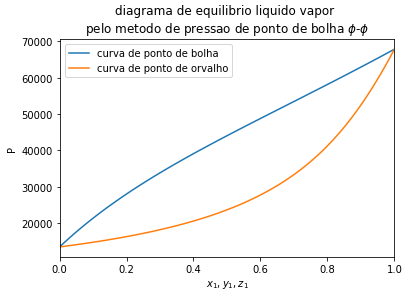

In [14]:
plt.title('diagrama de equilibrio liquido vapor \n'r'pelo metodo de pressao de ponto de bolha $\phi$-$\phi$')
plt.plot(vetor_x1,vetor_P,label='curva de ponto de bolha')
plt.plot(vetor_y1,vetor_P,label='curva de ponto de orvalho')
plt.ylabel('P')
plt.xlabel(r'$x_1,y_1,z_1$')
plt.legend()
plt.xlim(0,1)
plt.show()